# By: Thomas Isola
## Class: PUI 2018
## HW #11 Assignment 1

In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd
import urllib
import os

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load in the data
currentPath = os.getcwd()
if os.path.isfile('%s/MTAfare.npy' % currentPath):
    print("File in place. Continue.")
else:
    urllib.urlretrieve('https://github.com/fedhere/PUI2018_fb55/blob/master/HW11_fb55/MTA_Fare.npy?raw=true',
                  'MTAfare.npy');

File in place. Continue.


In [3]:
# Convert data into a numpy array
mta = np.load('MTAfare.npy')

In [4]:
# Print out information about the array
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


In [5]:
# Create an array of the ridership types
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


In [6]:
# Replace -1 with NaN
mta = np.where(mta ==-1, 'NaN', mta)

## Task 1: Event Detection

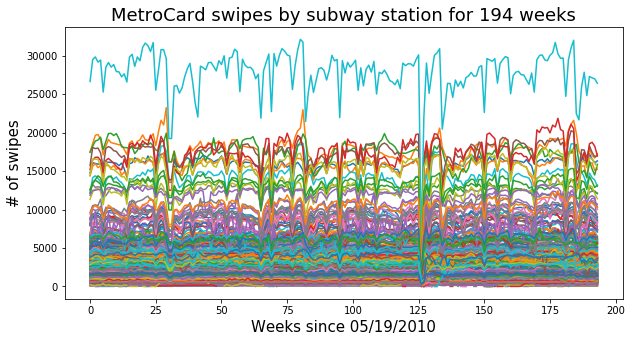

In [7]:
# Plot the data in natural space
mta = mta.astype('float64')

# 194 weeks from 05/19/2010 is 02/05/2014 so I used that as my end date
daterange = pd.date_range(start='05/19/2010', end='02/05/2014', freq='W')

dates = np.arange(0, 194, 1)
p1 = pl.figure(figsize=(10,5)).add_subplot(111);
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for i in range(600):
        p1.plot(dates, np.nanmean(mta[i,:], axis=0))
p1.set_title('MetroCard swipes by subway station for 194 weeks', fontsize=18);
p1.set_xlabel('Weeks since 05/19/2010', fontsize=15);
p1.set_ylabel('# of swipes', fontsize=15);

**Figure 1**: A plot of the number of swipes at 600 different subway stations for a period of 194 weeks starting from 05/19/2010. It appears that there is a significant drop in number of swipes around the 125th week.

In [8]:
# Create a log10 version of the array
mtalog = log10(mta)
mtalog = np.where(mtalog==-inf, 'NaN', mtalog)

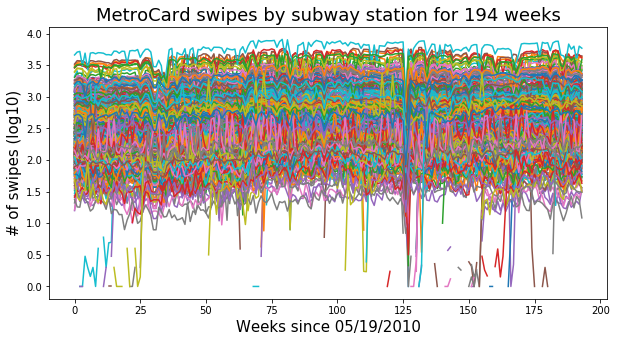

In [9]:
# Plot the data in log space
mtalog = mtalog.astype('float64')
p2 = pl.figure(figsize=(10,5)).add_subplot(111);
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for i in range(600):
        p2.plot(dates, np.nanmean(mtalog[i,:], axis=0))
p2.set_title('MetroCard swipes by subway station for 194 weeks', fontsize=18);
p2.set_xlabel('Weeks since 05/19/2010', fontsize=15);
p2.set_ylabel('# of swipes (log10)', fontsize=15);

**Figure 2**: A plot of the log10(number of swipes) at 600 different subway stations over a period of 194 weeks starting from 05/19/2010. There appears to be a significant dip in the number of MetroCard swipes around the 125th week mark.

From the results of Figure 1 and Figure 2, given that there was a dip in number of swipes about 125 weeks after 05/19/2010, I searched the internet for impactful events around that time and found out the Hurricane Sandy occurred at the end of October 2012. This corresponds to about 127 weeks after 05/19/2010 so therefore this is the likely candidate for the event that caused the drop in number of swipes.

## Task 2: Finding Trends

In [10]:
# Collapse the mta array along the 0 axis to find the average swipes for each card type over all stations
mta2 = np.nanmean(mta, axis=0)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


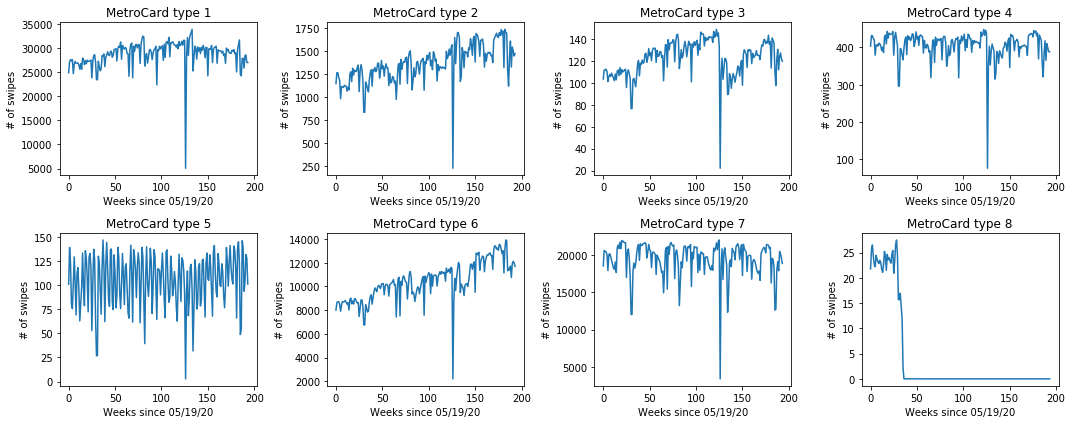

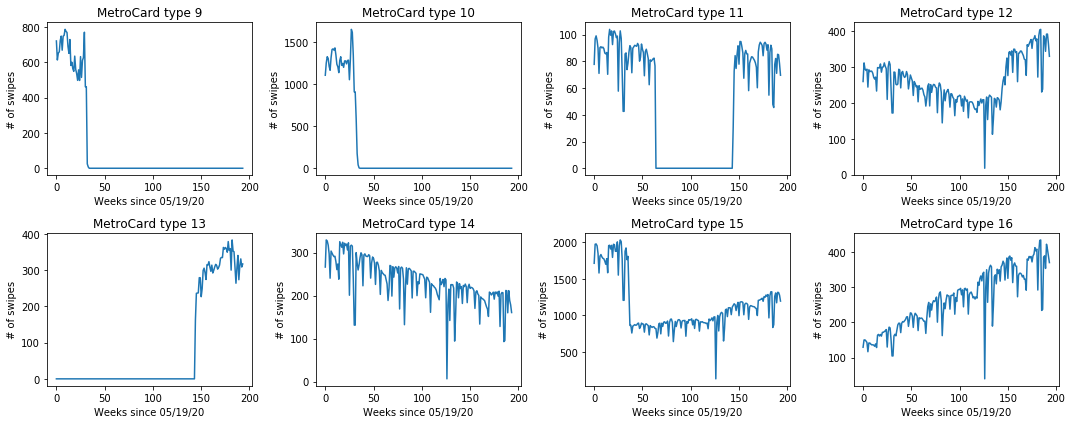

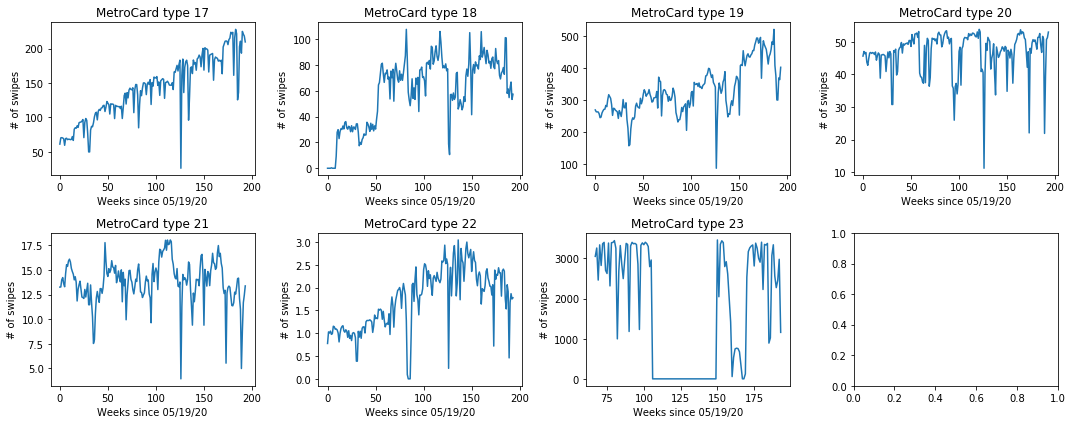

In [11]:
# Plot the data for the 23 MetroCard types
fig, ax = plt.subplots(2,4, figsize=(15,6))
ax = ax.flatten()
#fig.suptitle('Number of swipes over 194 weeks for each MetroCard type', fontsize=12)
for i in range(8):
    ax[i].plot(dates, mta2[i,:])
    ax[i].set_xlabel('Weeks since 05/19/20')
    ax[i].set_ylabel('# of swipes')
    ax[i].set_title('MetroCard type %s'%(i+1))
    pl.tight_layout()
    
j = 8
fig, ax = plt.subplots(2,4, figsize=(15, 6))
ax = ax.flatten()
for i in range(8):
    ax[i].plot(dates, mta2[j,:])
    ax[i].set_xlabel('Weeks since 05/19/20')
    ax[i].set_ylabel('# of swipes')
    ax[i].set_title('MetroCard type %s'%(j+1))
    pl.tight_layout()
    j = j + 1

j = 16
fig, ax = plt.subplots(2,4, figsize=(15, 6))
ax = ax.flatten()
for i in range(7):
    ax[i].plot(dates, mta2[j,:])
    ax[i].set_xlabel('Weeks since 05/19/20')
    ax[i].set_ylabel('# of swipes')
    ax[i].set_title('MetroCard type %s'%(j+1))
    pl.tight_layout()
    j = j + 1

**Figure 4**: A plot of the number of swipes for each MetroCard type over the 194 week period. This is for assistance in determining the trends for each MetroCard type.

### Comments
By visual inspection, I will focus on the following MetroCard types for determining the steepest steadily increasing and steepest steadily decreasing types:

Steepest Steadily Increasing: 2, 3, 6, 16, 17, 19, 22

Steepest Steadily Decreasing: 14

Because only one MetroCard type is steadily decreasing (type 14), that is the type that is identified as having the steepest decrease. Therefore, I will now calculate ratios to determine the steepest increasing type. I will also calculate the ratio for type 14 just to show.

In [12]:
# Calculate ratio of steadily decreasing type 14
ratiolow = mta2[13, 184:194].sum() / mta2[13, 0:10].sum()
print("The fraction change over time for type 14 is %.2f \n " %ratiolow)

# Calculating ratios of steadily increasing types
ratiohigh2 = mta2[1, 184:194].sum() / mta2[1, 0:10].sum()
print("The fraction change over time for type 2 is %.2f" %ratiohigh2)

ratiohigh3 = mta2[2, 184:194].sum() / mta2[2, 0:10].sum()
print("The fraction change over time for type 3 is %.2f" %ratiohigh3)

ratiohigh6 = mta2[5, 184:194].sum() / mta2[5, 0:10].sum()
print("The fraction change over time for type 6 is %.2f" %ratiohigh6)

ratiohigh16 = mta2[15, 184:194].sum() / mta2[15, 0:10].sum()
print("The fraction change over time for type 16 is %.2f" %ratiohigh16)

ratiohigh17 = mta2[16, 184:194].sum() / mta2[16, 0:10].sum()
print("The fraction change over time for type 17 is %.2f" %ratiohigh17)

ratiohigh19 = mta2[18, 184:194].sum() / mta2[18, 0:10].sum()
print("The fraction change over time for type 19 is %.2f" %ratiohigh19)

ratiohigh22 = mta2[21, 184:194].sum() / mta2[21, 0:10].sum()
print("The fraction change over time for type 22 is %.2f" %ratiohigh22)

The fraction change over time for type 14 is 0.58 
 
The fraction change over time for type 2 is 1.25
The fraction change over time for type 3 is 1.11
The fraction change over time for type 6 is 1.39
The fraction change over time for type 16 is 2.60
The fraction change over time for type 17 is 2.91
The fraction change over time for type 19 is 1.53
The fraction change over time for type 22 is 1.66


Based on these results, the steepest steadily decreasing type is type 14 (Monthly) and the steepest steadily increasing type is type 17 (Senior Citizen/Disabled). 

## Take 3: Build models that classify the ride type based on the time series characteristics using random forests.

In [114]:
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
validstations = stationid[mta.reshape(600*23, 194).std(1) > 0]

In [111]:
# Create first input feature (the time series mean divided by the mean of all time series for that station)
stationsmeans = np.nanmean(np.nanmean(mta, axis=1), axis=1).reshape(600, 1)
normedmeans = np.nanmean(mta, axis=2) / stationsmeans
normedmeans.shape

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


(600, 23)

In [113]:
# Create second input feature (the time series mean divided by the mean of all time series for that station)
stationsstd = np.nanstd(np.nanstd(mta, axis=1), axis=1).reshape(600, 1)
normedstd = np.nanstd(mta, axis=2) / stationsstd
normedstd.shape

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


(600, 23)

In [138]:
# Standardize the time features in preparation for creating the third and fourth input features
mta3 = mta
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for i in range(600):
        for j in range(23):
            mta3[i][j] = mta3[i][j] / nanmean(mta3[i][j]);

In [189]:
# Create the third and fourth input features
test1 = np.concatenate([np.array(arange(194)) for i in range(23)]).reshape(23,194)
endo = np.concatenate([test1 for i in range(600)]).reshape(600,23,194)
allfits = sm.OLS(mta3, endo)
[a.params[0] for a in allfits[:10]]

ValueError: exog is not 1d or 2d

In [166]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              normedmeans, normedstd]).T, 
    label, test_size=0.33, random_state=42, shuffle=True)

TypeError: 'OLS' object is not iterable